# Pachete necesare pentru folosirea acestui Notebook

Vom folosi [scipy](https://scipy.org/), [numpy](https://numpy.org/) și [matplotlib](https://matplotlib.org/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc, ndimage
from scipy.fft import dctn, idctn
# am folosit pt a incarca imaginile din video
import cv2



# Imaginea cu care lucrăm

Vom folosi o imagine din setul de date oferit implicit de către scipy.

C:\Users\SEBI\AppData\Local\Temp\ipykernel_21724\866361824.py:1: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  X = misc.ascent()


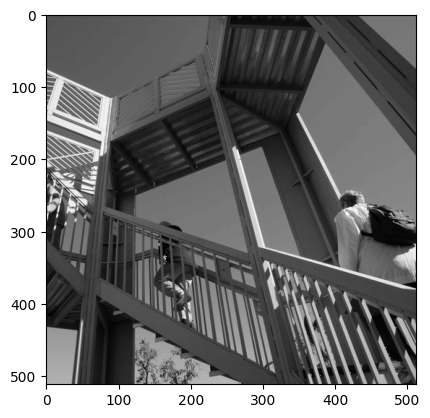

In [2]:
X = misc.ascent()
plt.imshow(X, cmap=plt.cm.gray)
plt.show()

# Transformata DCT a unei imagini

Transformata DCT se extinde la mai multe dimensiuni similar cu transformata DFT. Pentru un semnal bidimensional, precum o imagine, DCT-II devine:

$$
Y_{m_1,m_2} = \sum_{n_1=0}^{N_1-1}
              \sum_{n_2=0}^{N_2-1}
              x_{n_1,n_2}
              \cos\left[\frac{\pi}{N_1}m_1
                \left(n_1 + \frac12\right)\right]
              \cos\left[\frac{\pi}{N_2}m_2\left(n_2 + \frac12\right)\right]
$$

* unde $n_1$ și $n_2$ sunt pozițile pixelilor pe orizontală, respectiv, pe verticală
* bin-urile rezultate corespund pozițiilor pixelilor
* spectrul este în continuare simetric și par
* proprietățile transformatei DCT-II sunt respectate și în cazul celei 2D

În Python avem rutina `scipy.fft.dct` pentru 1D și `scipy.fft.dctn` pentru generalizarea la semnale $n$-dimensionale. Dimensiunea este determinată automat după forma semnalului; tipul DCT poate fi specificat prin atributul `type` (implicit II).

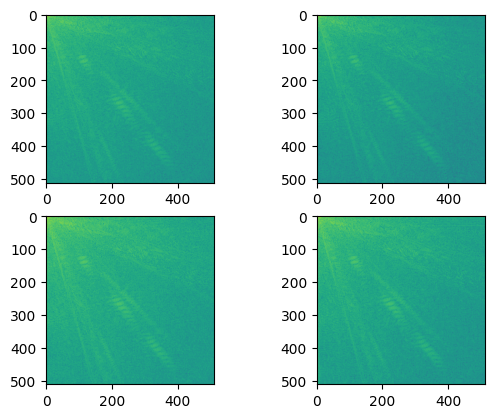

In [3]:
Y1 = dctn(X, type=1)
Y2 = dctn(X, type=2)
Y3 = dctn(X, type=3)
Y4 = dctn(X, type=4)
freq_db_1 = 20*np.log10(abs(Y1))
freq_db_2 = 20*np.log10(abs(Y2))
freq_db_3 = 20*np.log10(abs(Y3))
freq_db_4 = 20*np.log10(abs(Y4))

plt.subplot(221).imshow(freq_db_1)
plt.subplot(222).imshow(freq_db_2)
plt.subplot(223).imshow(freq_db_3)
plt.subplot(224).imshow(freq_db_4)
plt.show()

# Compactarea energiei. Compresie.

Putem profita de proprietatea compresiei energiei prin anularea frecvențelor DCT începând cu *bin*-ul `k` după care aplicăm transformata DCT inversă (similar cu tema anterioară):

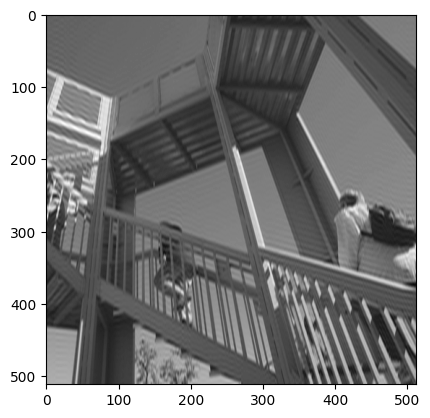

In [4]:
k = 120

Y_ziped = Y2.copy()
Y_ziped[k:] = 0
X_ziped = idctn(Y_ziped)

plt.imshow(X_ziped, cmap=plt.cm.gray)
plt.show()

# JPEG

Algoritmul de compresie JPEG are patru etape:

1. transformarea imaginii din pixeli RGB în Y'CbCr
2. aplicarea 2D-DCT pe blocuri disincte de 8x8 pixeli din imagine
3. cuantizarea în frecvență cu $Q$ dat de standardul JPEG
4. opțional compresia rezultatului cu coduri Huffman

Unde matricea JPEG de cuantizare $Q$ este:
$$
Q =
\begin{bmatrix}
16 & 11 & 10 & 16 & 24 & 40 & 51 & 61 & \\
12 & 12 & 14 & 19 & 26 & 28 & 60 & 55 & \\
14 & 13 & 16 & 24 & 40 & 57 & 69 & 56 & \\
14 & 17 & 22 & 29 & 51 & 87 & 80 & 62 & \\
18 & 22 & 37 & 56 & 68 & 109 & 103 & 77 & \\
24 & 35 & 55 & 64 & 81 & 104 & 113 & 92 & \\
49 & 64 & 78 & 87 & 103 & 121 & 120 & 101\\
72 & 92 & 95 & 98 & 112 & 100 & 103 & 99\\
\end{bmatrix}
$$

Imaginea noastră de test este monocromă, deci nu necesită pasul 1, dar putem efectua o operație de *down-sampling* în preprocesare precum am prezentat la curs.

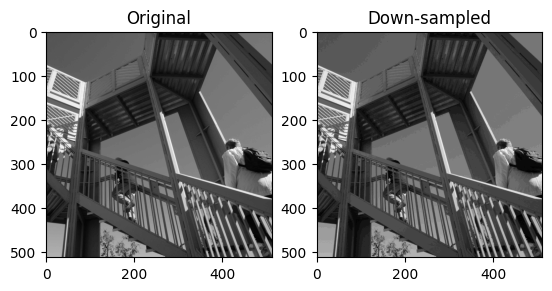

In [5]:
Q_down = 10

X_jpeg = X.copy()
X_jpeg = Q_down*np.round(X_jpeg/Q_down);

plt.subplot(121).imshow(X, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('Down-sampled')
plt.show()

Pentru fiecare bloc de $8\times 8$ aplică DCT și cuantizare.

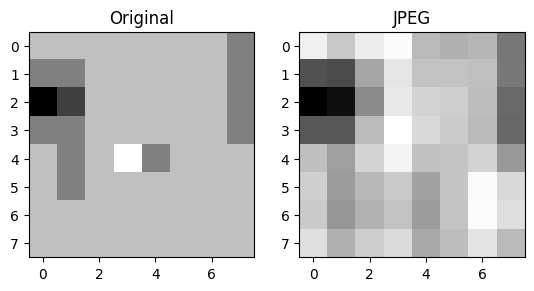

Componente în frecvență:64
Componente în frecvență după cuantizare: 14


In [6]:
Q_jpeg = [[16, 11, 10, 16, 24, 40, 51, 61],
          [12, 12, 14, 19, 26, 28, 60, 55],
          [14, 13, 16, 24, 40, 57, 69, 56],
          [14, 17, 22, 29, 51, 87, 80, 62],
          [18, 22, 37, 56, 68, 109, 103, 77],
          [24, 35, 55, 64, 81, 104, 113, 92],
          [49, 64, 78, 87, 103, 121, 120, 101],
          [72, 92, 95, 98, 112, 100, 103, 99]]

# Encoding
x = X[:8, :8]
y = dctn(x)
y_jpeg = Q_jpeg*np.round(y/Q_jpeg)

# Decoding
x_jpeg = idctn(y_jpeg)

# Results
y_nnz = np.count_nonzero(y)
y_jpeg_nnz = np.count_nonzero(y_jpeg)

plt.subplot(121).imshow(x, cmap=plt.cm.gray)
plt.title('Original')
plt.subplot(122).imshow(x_jpeg, cmap=plt.cm.gray)
plt.title('JPEG')
plt.show()

print('Componente în frecvență:' + str(y_nnz) + 
      '\nComponente în frecvență după cuantizare: ' + str(y_jpeg_nnz))

# Sarcini

1. [6p] Completați algoritmul JPEG incluzând toate blocurile din imagine.

2. [4p] Extindeți la imagini color (incluzând transformarea din RGB în Y'CbCr). Exemplificați pe `scipy.misc.face` folosită în tema anterioară.

3. [6p] Extindeți algoritmul pentru compresia imaginii până la un prag MSE impus de utilizator.

4. [4p] Extindeți algoritmul pentru compresie video. Demonstrați pe un clip scurt din care luați fiecare cadru și îl tratați ca pe o imagine.

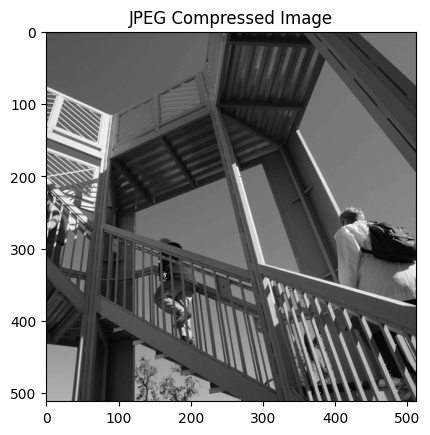

In [7]:
# 1
H, W = X.shape
# Parcurgerea fiecărui bloc de 8x8
for i in range(0, H, 8):
    for j in range(0, W, 8):
        # Extragerea blocului
        block = X[i:i+8, j:j+8]
        # DCT
        dct_block = dctn(block)
        quantized_block = np.round(dct_block / Q_jpeg) * Q_jpeg
        block_jpeg = idctn(quantized_block)
        X_jpeg[i:i+8, j:j+8] = block_jpeg

plt.imshow(X_jpeg, cmap=plt.cm.gray)
plt.title('JPEG Compressed Image')
plt.show()

C:\Users\SEBI\AppData\Local\Temp\ipykernel_4688\2416807003.py:1: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  image_rgb = misc.face()


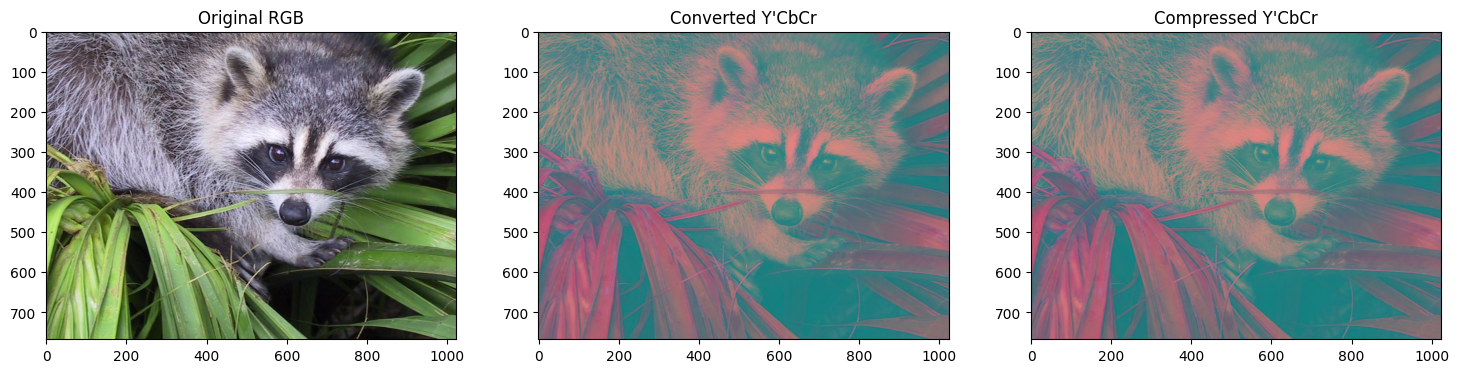

In [8]:
image_rgb = misc.face()

# Funcția de conversie din RGB în Y'CbCr
# https://sistenix.com/rgb2ycbcr.html de aici am luat valorile 
def rgb_to_ycbcr(image):
    Y = 16 + (65.738 * image[:,:,0] / 256) + (129.057 * image[:,:,1] / 256) + (25.064 * image[:,:,2] / 256)
    Cb = 128 - (37.945 * image[:,:,0] / 256) - (74.494 * image[:,:,1] / 256) + (112.439 * image[:,:,2] / 256)
    Cr = 128 + (112.439 * image[:,:,0] / 256) - (94.154 * image[:,:,1] / 256) - (18.285 * image[:,:,2] / 256)
    return np.stack((Y, Cb, Cr), axis=-1)

image_ycbcr = rgb_to_ycbcr(image_rgb)

def process_block(block):
    dct_block = dctn(block, type=2)
    quantized_block = np.round(dct_block / Q_jpeg)
    return quantized_block

def process_block_inverse(block):
    dequantized_block = block * Q_jpeg
    return idctn(dequantized_block, type=2)

# Funcție pentru procesarea unui canal întreg
def process_channel(channel):
    height, width = channel.shape
    compressed_channel = np.zeros_like(channel)
    for i in range(0, height, 8):
        for j in range(0, width, 8):
            block = channel[i:i+8, j:j+8]
            compressed_block = process_block(block)
            compressed_channel[i:i+8, j:j+8] = process_block_inverse(compressed_block)
    return compressed_channel

# Aplică procesul pentru cele 3 canale Y Cb Cr
Y_compressed = process_channel(image_ycbcr[:,:,0])
Cb_compressed = process_channel(image_ycbcr[:,:,1])
Cr_compressed = process_channel(image_ycbcr[:,:,2])

# Le suprapune pentru a obține imaginea finală
image_ycbcr_compressed = np.stack((Y_compressed, Cb_compressed, Cr_compressed), axis=-1)

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original RGB")
plt.subplot(1, 3, 2)
plt.imshow(np.uint8(image_ycbcr))
plt.title("Converted Y'CbCr")
plt.subplot(1, 3, 3)
plt.imshow(np.uint8(image_ycbcr_compressed))
plt.title("Compressed Y'CbCr")
plt.show()


1.0
0.9090909090909091
0.8264462809917354
0.7513148009015777
0.6830134553650705
0.6209213230591549
0.5644739300537771
0.5131581182307065
0.4665073802097331
0.4240976183724846
0.3855432894295314
0.35049389948139215
0.31863081771035645
0.2896643797366877
0.2633312543060797
0.23939204936916333
0.21762913579014848
0.19784466890013497
0.17985878990921358
0.1635079908265578
0.14864362802414344
0.13513057093103947
0.12284597357367223
0.11167815779424747
0.10152559799477043
0.09229599817706402
0.08390545288824001
1.0
0.9090909090909091
0.8264462809917354
0.7513148009015777
0.6830134553650705
0.6209213230591549
0.5644739300537771
0.5131581182307065
0.4665073802097331
0.4240976183724846
0.3855432894295314
0.35049389948139215
0.31863081771035645
0.2896643797366877
0.2633312543060797
0.23939204936916333
0.21762913579014848
0.19784466890013497
0.17985878990921358
0.1635079908265578
0.14864362802414344
0.13513057093103947
0.12284597357367223
0.11167815779424747
0.10152559799477043
1.0
0.909090909090

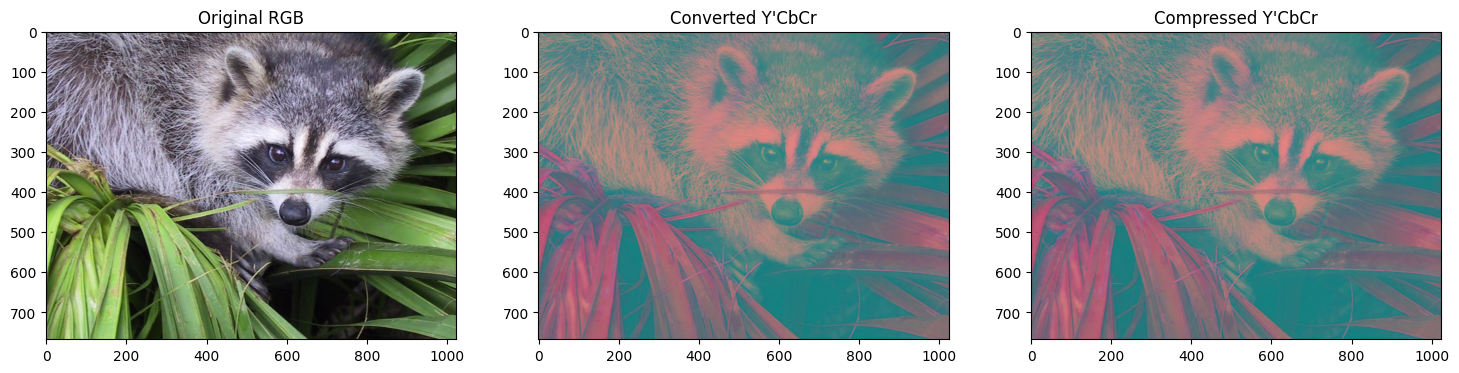

MSE pentru canalul Y: 0.009585521531989266
MSE pentru canalul Cb: 0.008939353684468071
MSE pentru canalul Cr: 0.00882772097107906


In [11]:

def calculate_mse(original, compressed):
    return np.mean((original - compressed) ** 2)

# Funcție pentru ajustarea matricei de cuantizare
# Echilibrul între Compresie și Calitate: Scopul este de a alege o matrice de cuantizare care 
# oferă un echilibru între dimensiunea fișierului și calitatea imaginii. O matrice de cuantizare cu 
# valori mai mari va reduce mai mult dimensiunea fișierului (prin creșterea compresiei), dar va crește și MSE
# (scăzând calitatea imaginii). Pe de altă parte, o matrice cu valori mai mici va păstra o calitate mai bună a imaginii
# (MSE mai mic), dar va rezulta într-un fișier de dimensiune mai mare.

# am redefinit matrice aici ptc aveam nevoie la scalarea ei
Q_jpeg = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

def adjust_quantization_matrix(Q, factor):
    return Q * factor

def compress_to_mse_threshold(channel, mse_threshold):
    factor = 1.1
    
    mse = float('inf')
    while mse > mse_threshold:
        adjusted_Q = adjust_quantization_matrix(Q_jpeg, factor)
        compressed_channel = np.zeros_like(channel)
        height, width = channel.shape
        for i in range(0, height, 8):
            for j in range(0, width, 8):
                block = channel[i:i+8, j:j+8]
                dct_block = dctn(block, type=2)
                quantized_block = np.round(dct_block / adjusted_Q)
                dequantized_block = quantized_block * adjusted_Q
                compressed_channel[i:i+8, j:j+8] = idctn(dequantized_block, type=2)
        mse = calculate_mse(channel, compressed_channel)
        factor /= 1.1  # Ajustează factorul pentru a modifica gradul de compresie
    return compressed_channel, mse

# Aplicam procesul pt cele 3 canale
mse_threshold = 0.01  # am observat ca MSE este destul de mic asa ca am ales un prag mai mic
Y_compressed, mse_Y = compress_to_mse_threshold(image_ycbcr[:,:,0], mse_threshold)
Cb_compressed, mse_Cb = compress_to_mse_threshold(image_ycbcr[:,:,1], mse_threshold)
Cr_compressed, mse_Cr = compress_to_mse_threshold(image_ycbcr[:,:,2], mse_threshold)

image_ycbcr_compressed = np.stack((Y_compressed, Cb_compressed, Cr_compressed), axis=-1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(image_rgb)
plt.title("Original RGB")

plt.subplot(1, 3, 2)
plt.imshow(np.uint8(image_ycbcr))
plt.title("Converted Y'CbCr")

plt.subplot(1, 3, 3)
plt.imshow(np.uint8(image_ycbcr_compressed))
plt.title("Compressed Y'CbCr")
plt.show()

print(f"MSE pentru canalul Y: {mse_Y}")
print(f"MSE pentru canalul Cb: {mse_Cb}")
print(f"MSE pentru canalul Cr: {mse_Cr}")

In [22]:
# https://jsoncompare.org/LearningContainer/SampleFiles/Video/MP4/Sample-MP4-Video-File-for-Testing.mp4
video_path = 'video-test.mp4'

cap = cv2.VideoCapture(video_path)

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Am micșorat numărul de cadre pentru a reduce timpul de procesare
# initial erau toate cele 30 de secunde si dura > 5 min
num_frames_to_process = int(fps * 1)

# Definește codec-ul și crează un obiect VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output_video.avi', fourcc, fps, (frame_width, frame_height))

# Funcția de compresie pentru cadre
def compress_frame(frame):
    # Convertim cadru din BGR (OpenCV) în RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Aplică compresia pe fiecare canal al fiecărui bloc de 8x8 pixeli
    compressed_frame = np.zeros_like(frame_rgb)
    for channel in range(3):
        for i in range(0, frame_rgb.shape[0], 8):
            for j in range(0, frame_rgb.shape[1], 8):
                block = frame_rgb[i:i+8, j:j+8, channel]
                compressed_block = process_block(block)
                decompressed_block = process_block_inverse(compressed_block)
                compressed_frame[i:i+8, j:j+8, channel] = decompressed_block
    
    # Convertim înapoi în BGR pentru OpenCV
    compressed_bgr = cv2.cvtColor(compressed_frame.astype('uint8'), cv2.COLOR_RGB2BGR)
    return compressed_bgr

# Citirea și procesarea fiecărui cadru
frames_processed = 0
while cap.isOpened() and frames_processed < num_frames_to_process:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Comprimă cadru
    compressed_frame = compress_frame(frame)

    # Scrie cadru în videoclipul de ieșire
    out.write(compressed_frame)

    # Incrementăm contorul de cadre procesate
    frames_processed += 1

# Eliberează obiectele și închide ferestrele
cap.release()
out.release()


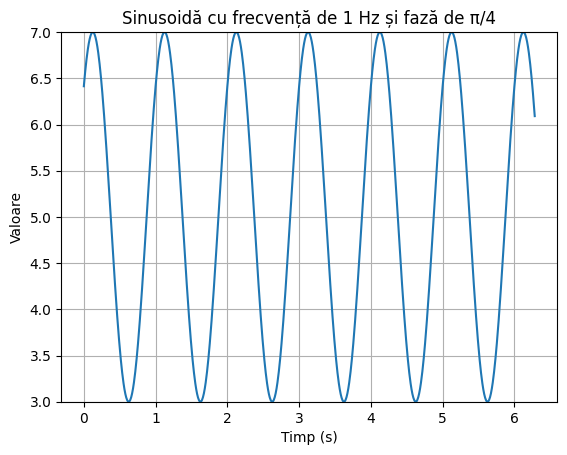

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parametrii sinusoidalei
frecventa = 1  # Hz, alegem o frecvență de 1 Hz
faza = np.pi / 4  # Radiani, alegem o fază de π/4

# Crearea sinusoidalei
t = np.linspace(0, 2 * np.pi, 1000)  # Intervalul de timp (2 cicluri)
sinusoida = 2 * np.sin(2 * np.pi * frecventa * t + faza) + 5  # Ajustăm amplitudinea și offset-ul

# Afișarea graficului
plt.plot(t, sinusoida)
plt.title("Sinusoidă cu frecvență de 1 Hz și fază de π/4")
plt.xlabel("Timp (s)")
plt.ylabel("Valoare")
plt.ylim([3, 7])
plt.grid(True)
plt.show()
